In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test
from sklearn.metrics import mean_absolute_error
import os

In [2]:
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)

In [3]:

class CustomRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        if cell_type == "RNN":
            self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size,
                               num_layers=num_layers, batch_first=True,
                               bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_size * self.num_directions, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.linear(pred).view(pred.data.shape[0], -1, 1)
        pred = torch.min(pred, x)
        return pred

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.conv2(bn1))        
        e5 = self.bn5(self.conv5(e2))
        e6 = self.conv6(e5)
        return e6

In [4]:
def preprocess(train, valid, test):
    out_train = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_train[a_num] = Variable(
            torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
        if cuda_av:
            out_train[a_num] = out_train[a_num].cuda()

    out_valid = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_valid[a_num] = Variable(
            torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
        if cuda_av:
            out_valid[a_num] = out_valid[a_num].cuda()
            
    out_test = [None for temp in range(len(ORDER))]
    for a_num, appliance in enumerate(ORDER):
        out_test[a_num] = Variable(
            torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
        if cuda_av:
            out_test[a_num] = out_test[a_num].cuda()

    return out_train, out_valid, out_test

In [50]:
class AppliancesRNNCNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional, num_appliance):
        super(AppliancesRNNCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if ORDER[appliance] in ['fridge']:
                print("use RNN")
                if cuda_av:
                    setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type, hidden_size,
                                                                           num_layers, bidirectional).cuda())
                else:
                    setattr(self, "Appliance_" + str(appliance), CustomRNN(cell_type, hidden_size,
                                                                           num_layers, bidirectional))
            else:
                print("use CNN")
                if cuda_av:
                    setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
                else:
                    setattr(self, "Appliance_" + str(appliance), CustomCNN())


    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            agg_current = agg_current.contiguous()
            if ORDER[appliance] in ['fridge']:
                agg_current = agg_current.view(agg_current.shape[0], -1, 1)
            else:
                agg_current = agg_current.view(agg_current.shape[0], 1, -1, 24)
            
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            
            agg_current = agg_current.view(agg_current.shape[0], 1, -1, 24)
            self.preds[appliance] = self.preds[appliance].view(self.preds[appliance].shape[0], 1, -1, 24)
            
            
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [51]:
dataset = 3
fold_num = 3
num_folds = 5
origin_train, origin_test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [52]:
# create the residual column
train_residual = origin_train[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
train = np.hstack((origin_train, train_residual))

In [53]:
# create the residual column
test_residual = origin_test[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
test = np.hstack((origin_test, test_residual))

In [54]:
APPLIANCE_ORDER=['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw', 'residual']

In [55]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()
train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [56]:
ORDER = ['dr', 'fridge', 'residual', 'hvac','dw', 'mw']
# ORDER = ORDER[::-1]
out_train, out_valid, out_test = preprocess(train, valid, test)

In [57]:
inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()
    valid_inp = valid_inp.cuda()
    test_inp = test_inp.cuda()
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [79]:
loss_func = nn.L1Loss()
model = AppliancesRNNCNN('GRU', 20, 1, True, len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
p=0
params = [inp, p]

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()
    
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])

if cuda_av:
    train_out = train_out.cuda()

use CNN
use RNN
use CNN
use CNN
use CNN
use CNN


In [80]:
for k in range(500):
    pred = model(*params)
    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    
    
    
    if cuda_av:
        test_inp = test_inp.cuda()
    test_params = [test_inp, -2]
    for i in range(len(ORDER)):
        test_params.append(None)
    test_pr = model(*test_params)
    test_loss = loss_func(test_pr, test_out)
    
    print(k, loss.data[0], test_loss.data[0])

    loss.backward()
    optimizer.step()

0 356.53350830078125 353.7862854003906
1 356.2173156738281 353.4793701171875
2 355.42779541015625 352.76739501953125
3 353.56658935546875 350.8727722167969
4 351.5331726074219 348.9730529785156
5 348.5419921875 346.0857238769531
6 344.98284912109375 342.6145935058594
7 340.6120910644531 338.457275390625
8 335.3240966796875 333.4629211425781
9 329.1043395996094 327.7042236328125
10 322.0245361328125 321.1148376464844
11 314.0142517089844 313.6829528808594
12 305.0313720703125 305.6879577636719
13 294.9853820800781 296.5195007324219
14 283.9573974609375 286.86285400390625
15 271.9574890136719 276.2972106933594
16 258.8981018066406 265.1287536621094
17 245.2588653564453 253.56961059570312
18 231.4821014404297 241.45162963867188
19 217.8900146484375 232.70486450195312
20 202.651611328125 219.9980926513672
21 189.1016082763672 210.69100952148438
22 178.68441772460938 205.0570831298828
23 169.61044311523438 196.71958923339844
24 158.74453735351562 192.4138946533203
25 159.67337036132812 196.

203 115.60597229003906 164.70924377441406
204 115.42169189453125 163.84463500976562
205 115.7393798828125 163.34019470214844
206 115.9096908569336 164.52859497070312
207 115.24949645996094 163.5325927734375
208 115.2028579711914 163.43043518066406
209 115.15058135986328 163.7792510986328
210 114.3879165649414 163.3711700439453
211 114.74634552001953 163.30398559570312
212 114.985107421875 164.57009887695312
213 114.98713684082031 162.5987091064453
214 116.33683776855469 165.52645874023438
215 120.1762466430664 164.35398864746094
216 116.69371032714844 165.865234375
217 115.43893432617188 162.39918518066406
218 116.84423828125 162.409912109375
219 115.2407455444336 164.0355224609375
220 115.86105346679688 164.0711669921875
221 115.30908203125 161.02561950683594
222 114.8773193359375 162.5868377685547
223 115.3040771484375 164.44876098632812
224 114.22193145751953 162.02731323242188
225 114.61346435546875 162.76487731933594
226 113.82917022705078 162.8697967529297
227 113.8672866821289 1

402 99.70196533203125 149.62692260742188
403 99.84529113769531 149.68084716796875
404 99.65336608886719 149.87203979492188
405 99.86654663085938 150.3488311767578
406 99.94713592529297 149.07882690429688
407 101.20326232910156 151.19773864746094
408 102.9233169555664 150.15530395507812
409 102.68289184570312 153.7037811279297
410 100.19425201416016 149.29299926757812
411 100.9339599609375 148.52830505371094
412 101.40205383300781 150.79052734375
413 100.24263763427734 151.31581115722656
414 99.5019302368164 149.0958709716797
415 101.22799682617188 149.94544982910156
416 100.7734603881836 149.63890075683594
417 99.52188110351562 151.50094604492188
418 99.18094635009766 148.97923278808594
419 100.14832305908203 148.51251220703125
420 99.7710952758789 151.5628662109375
421 98.95411682128906 150.38671875
422 99.25357055664062 147.968505859375
423 99.84656524658203 149.27813720703125
424 99.20154571533203 150.22215270996094
425 99.04293823242188 149.89930725097656
426 98.74388885498047 148.

In [19]:
import numpy as np
import itertools
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append("../code/")
from dataloader import get_train_test
import pandas as pd

In [81]:
test_pred = torch.split(test_pr, test_aggregate.shape[0])
test_fold = [None for x in range(len(ORDER))]
if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        test_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        test_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)

In [82]:
test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    print(appliance_num, appliance)
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

0 dr
1 fridge
2 residual
3 hvac
4 dw
5 mw


In [83]:
test_error = {}

for appliance_num, appliance in enumerate(ORDER):
    test_error[appliance] = mean_absolute_error(test_fold[appliance_num], test_gt_fold[appliance_num])

In [84]:
test_error

{'dr': 83.073210074429525,
 'dw': 20.602055528907556,
 'fridge': 31.841900517104573,
 'hvac': 376.0803000773746,
 'mw': 5.6529535734487624,
 'residual': 376.09168160878897}

In [78]:
test_error

{'dr': 83.052269430245204,
 'dw': 20.612454579551606,
 'fridge': 31.649631276178969,
 'hvac': 385.0988294568254,
 'mw': 5.8155400524336569,
 'residual': 383.32513222150027}

In [34]:
pred = np.load("../code/cnn_rnn_residual.npy")

In [35]:
test_aggregate[0][0].shape

(112, 24)

In [40]:
ORDER.index('hvac')

3

In [50]:
test_gt_fold[3]

array([[  633.29998779,   613.29998779,   716.18334961, ...,
         1667.91662598,  1549.68334961,  3645.56665039],
       [ 4170.31689453,  2615.81665039,   844.7333374 , ...,
         1723.06665039,  1663.06665039,  1387.51672363],
       [ 1038.93334961,   846.20001221,   870.31665039, ...,
         1453.61669922,   904.09997559,   670.5166626 ],
       ..., 
       [  500.45001221,  6888.36669922,  1832.34997559, ...,
         1055.94995117,   838.88336182,   813.61663818],
       [  372.33334351,   398.2833252 ,   230.08332825, ...,
          451.91665649,   827.36663818,   815.88336182],
       [  555.56665039,  6924.66650391,  3580.88330078, ...,
          572.93334961,   903.61663818,   750.13336182]])

In [27]:
test_fold[3]

array([[ 0.07750428,  0.08671144,  0.10246564, ...,  0.13023974,
         0.08273464,  0.10448182],
       [ 0.05899549,  0.05223992,  0.11015422, ...,  0.07455975,
         0.01972076,  0.13222013],
       [ 0.08781143,  0.0728396 ,  0.10689173, ...,  0.15625095,
         0.06789164,  0.12791415],
       ..., 
       [ 0.1494118 ,  0.04695046,  0.25481755, ...,  0.09123659,
         0.04654347,  0.16041394],
       [ 0.06217813,  0.03337047,  0.08406292, ...,  0.12789235,
         0.06969883,  0.13166392],
       [ 0.09288365,  0.06897522,  0.13209109, ...,  0.09046839,
         0.03694388,  0.12192314]], dtype=float32)

AttributeError: 'Variable' object has no attribute 'reshape'

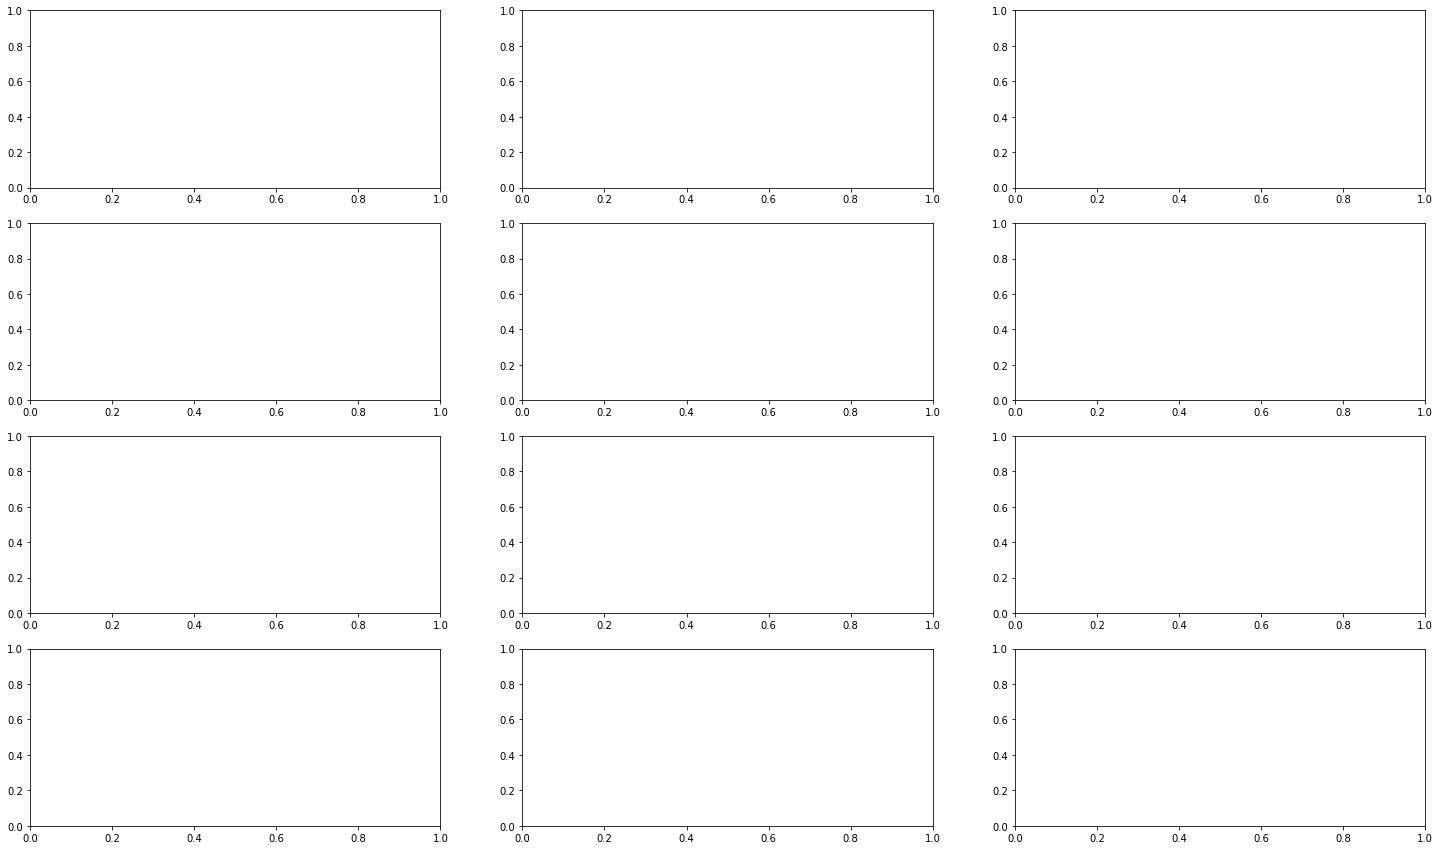

In [25]:
import seaborn as sns
fig, axes = plt.subplots(ncols=3, nrows = 4, figsize=(25, 15))
ax = axes.flatten()
homes = [0, 4, 8, 12]
appliance = 'dr'
idx = ORDER.index(appliance)
fold_num = 0

for i, home_id in enumerate(homes):
    sns.heatmap(pred[idx].reshape(-1, 112, 24)[home_id], ax=ax[i*3], cmap='Greens')
    sns.heatmap(test_gt_fold[idx].reshape(-1 ,112, 24)[home_id], ax=ax[i*3+1], cmap='Greens')
    sns.heatmap(test_aggregate[home_id][0], ax=ax[i*3+2], cmap='Greens')